# CAAM 519: Computational Science I
## Homework #4: Tensorflow
### Due date: Monday, 12/16 at 11am

Your fourth homework will require you to use TensorFlow to train a predictive model on a new data set, "fashion MNIST." You will be asked to implement "adversarial training", which will require that you customize the TensorFlow training loop. Just fill in the missing code below!

To submit this assignment, please create a directory named ``homework-4`` on your git repository, commit this (completed) notebook in that directory under the name ``adversarial.ipynb``, and git tag the final submission to the repository with the tag name ``homework-4``.

First, we load in the necessary libraries:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

import numpy as np
import matplotlib.pyplot as plt

Next, we load the "Fashion MNIST" data set. This is like the MNIST handwritten digit data set (i.e. it consists of 28x28 grayscale images), but the pictures are instead of clothing items. This makes the classification task a bit more difficult.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

__Task 1__: In the following cell, specify and train a simple neural network model to classify images from the Fashion MNIST data set. Be sure to use the training data (not test data) for the training. The model should 
1. flatten its inputs, then 
2. apply a Dense layer with the ReLU activation function, then finally 
3. apply a Dense layer with 10 outputs and the softmax activation function. 

Choose the network size and training features such that you attain >85% test accuracy on your final trained model.

In [3]:
# Inplement your model here! Make sure it is named "simple_model"
# simple_model = ...
simple_model = tf.keras.Sequential()
simple_model.add(tf.keras.layers.Flatten())
simple_model.add(tf.keras.layers.Dense(64, activation='relu'))
simple_model.add(tf.keras.layers.Dense(10, activation='softmax'))

simple_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

simple_model.fit(train_images,train_labels,epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 119us/sample - loss: 0.5266 - accuracy: 0.8191
Epoch 2/5
60000/60000 [==============================] - 6s 107us/sample - loss: 0.3958 - accuracy: 0.8589
Epoch 3/5
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3560 - accuracy: 0.8702
Epoch 4/5
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3315 - accuracy: 0.8791
Epoch 5/5
60000/60000 [==============================] - 6s 107us/sample - loss: 0.3134 - accuracy: 0.8866


In [4]:
test_loss, test_acc = simple_model.evaluate(test_images, test_labels, verbose=2)

10000/1 - 1s - loss: 0.2843 - accuracy: 0.8729


The following function will plot a handful of images, along with their predicted classification (and whether that it was right or wrong). 

In [5]:
def plot_images(X, y, yp, M, N):
    f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(2.0 * N, 2.0 * M))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(X[i*N+j], cmap=plt.cm.binary)
            title = ax[i][j].set_title("Pred: {}".format(class_names[yp[i*N+j].argmax()]))
            plt.setp(title, color=('g' if yp[i*N+j].argmax() == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

Run the following to illustrate some of the Fashion MNIST test images, along with which classes your model believes each belongs to.

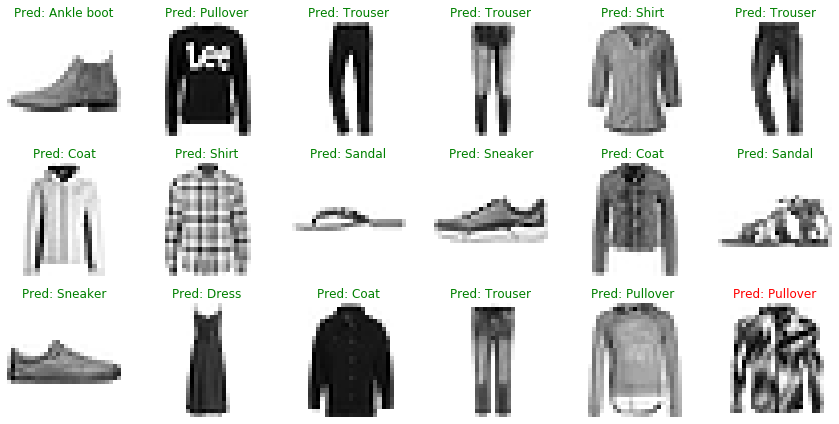

In [6]:
plot_images(test_images, test_labels, simple_model.predict(test_images), 3, 6)

__Task 2__: Implement the _fast gradient sign method_ to adversarially attack your network. Mathematically, this attack is of the form
$$
  \tilde{x} = x + \epsilon * \operatorname{sign}(\nabla_x \ell(\theta; x, y)),
$$
where 
* $x$ is an input image, 
* $y$ is its true label, 
* $\ell$ is the loss function with respect to current model parameters $\theta$ on the input/output pair $(x,y)$,
* $\epsilon > 0$ is some perturbation amount, and 
* $\operatorname{sign}$ returns $+1$ if its input is positive, and $-1$ otherwise.

Essentially, you compute the gradient of the loss function with respect to $x$ at the point $(x,y)$, and then throw away all information about the magnitude of the gradient, only recording its sign.

You will implement a method, ``fgsm``, which takes four arguments:
* ``model``: Your MyModel
* ``input_image``: A $N \times 28 \times 28$ ``tf.Tensor`` containing $N$ input images of size $28 \times 28$
* ``input_label``: A $N \times 10$ ``tf.Tensor`` containing $N$ labels in "one hot encoding". In row $i$, the $j$-th entry will contain a 1 if image $i$ is of class $j$, and a 0 otherwise.
* ``epsilon``: A positive floating point value.

The function should return a $N \times 28 \times 28$ ``tf.Tensor``. For each row $i$, presume that in the equation above $x$ is the $i$-th row of ``input_image``. Then the $i$-th row of the returned tensor should contain $\tilde{x}$ as defined above, _with the further constraint that you should clip the values of each entry of the perturbed image $\tilde{x}$ to lie in [0,1]_.

Hints: the way to compute gradients will be nearly identical to how it is done in ``train_step``. After that, you can use the ``tf.sign`` and ``tf.clip_by_value`` functions to finish the job.

In [7]:
def fgsm(model, input_image, input_label, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        loss = tf.keras.losses.categorical_crossentropy(input_label, predictions)
        
    gradients = tape.gradient(loss, input_image)
    sign_grad = tf.sign(gradients)
    output = input_image + epsilon*sign_grad
    output = tf.clip_by_value(output,0,1)
    return output

You can test your implementation visually using the following code:

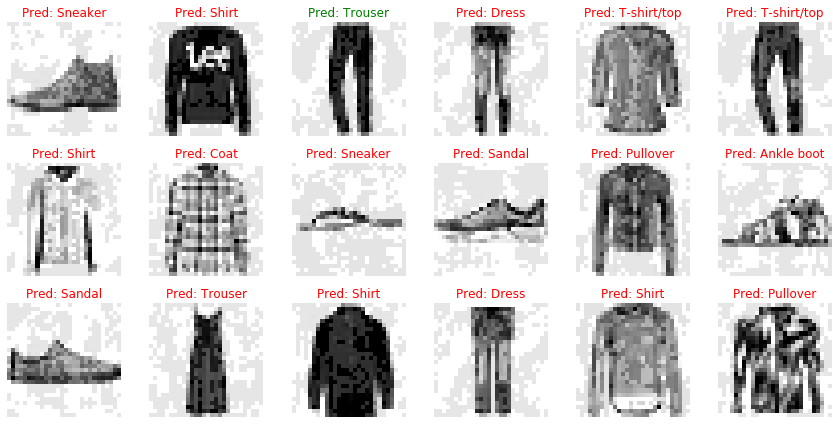

In [8]:
tensor_images = tf.convert_to_tensor(test_images)
tensor_one_hot_labels = tf.convert_to_tensor(tf.one_hot(test_labels, 10))
perturbed_images = fgsm(simple_model, tensor_images, tensor_one_hot_labels, 0.1)

plot_images(perturbed_images, test_labels, simple_model.predict(perturbed_images), 3, 6)

The images should qualitatively similar to the ones pictured above without the attack, but with gray splotches in the white background, seemingly at random. Despite their seemingly random nature, the attacks are successful! Most of the images should now be misclassified by your model.

However, all is not lost. We can use this adversary to make our model more robust by "playing against it" during the training algorithm. This is known as adversarial training. In standard training, you might do something like this:

```
initialize model parameters theta
for each epoch:
    for each minibatch of data B:
        theta = Update(theta, B)
```
Here, an epoch is an entire pass through the data. In each epoch, you split up the data set into minibatches, choosing a small subset of the data each time. Using that small subset, you update your model parameters through the ``Update`` method (i.e. the Adam updating rule).

__Task 3__: Implement adversarial training. Before each update to the model parameters, adversarial training applies an attack to the input data, perturbing it in the worst possible way (according to the current parameters of the model). The training ``Update`` step is then taken with respect to these adversarial input images:
```
initialize model parameters theta
for each epoch:
    for each minibatch of data B:
        perturbed_B = attack(B)
        theta = Update(theta, perturbed_B)
```
In your code, the ``attack`` method should be the ``fgsm`` method, implemented above, where the inputs correspond to each training image/label pair in the minibatch.

Below, I have provided you with the code from class that defines a custom Model with custom training behavior. All you have to do is modify the training loop to do support adversarial training.

Here is the set up code. Don't modify this cell!

In [9]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='softmax')
    
    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)
    
adv_model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

adversarial_loss = tf.keras.metrics.Mean(name='adversarial_loss')
adversarial_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='adversarial_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = adv_model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, adv_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, adv_model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)
    
    predictions = adv_model(images)
    loss = loss_object(labels, predictions)
    
    adversarial_loss(loss)
    adversarial_accuracy(labels,predictions)
    
@tf.function
def test_step(images, labels):
    predictions = adv_model(images)
    loss = loss_object(labels, predictions)
    
    test_loss(loss)
    test_accuracy(labels, predictions)

And the code to run training. Modify this cell to do adversarial training! Note that you will have to convert the labels (which are integers from 0 to 9) to a "one hot encoding" of this same data.

In [10]:
# mini-batched train and test data
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)


# Edit the training loop to do adversarial training
for epoch in range(5):
    for images, labels in train_ds:
        tensor_hot_labels = tf.convert_to_tensor(tf.one_hot(labels, 10))
        tensorimages = tf.convert_to_tensor(images)
        perturbed = fgsm(adv_model, tensorimages, tensor_hot_labels, 0.05)
        train_step(perturbed, labels)
        adversarial_loss
    
    for images, labels in test_ds:
        test_step(images, labels)
        
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, Adversarial Loss: {}, Adversarial Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result(),
                          adversarial_loss.result(),
                          adversarial_accuracy.result()))
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epoch 1, Loss: 0.8952316572030385, Accuracy: 0.6561666666666667, Test Loss: 0.5305670495040882, Test Accuracy: 0.8079, Adversarial Loss: 0.8771220708211263, Adversarial Accuracy: 0.6632
Epoch 2, Loss: 0.7425353421529134, Accuracy: 0.7163166666666667, Test Loss: 0.5072427675270805, Test Accuracy: 0.8209, Adversarial Loss: 0.8025451175053915, Adversarial Accuracy: 0.6925
Epoch 3, Loss: 0.7061428687254587, Accuracy: 0.7301333333333333, Test Loss: 0.507514145903694, Test Accuracy: 0.8082, Adversarial Loss: 0.7658866551876068, Adversarial Accuracy: 0.7066444444444444
Epoch 4, Loss: 0.684491426150004, Accuracy: 0.7371666666666666, Test Loss: 0.4830364235007344, Test Accuracy: 0.8232, Adversarial Loss: 0.7423225821495056, Adversarial Accuracy: 0.7154541666666666
Epoch 5, Loss: 0.6683913822730382, Accuracy: 0.7432, Test Loss: 0.4778776464466089, Test Accuracy: 0.8234, Adversarial Loss: 0.724993345635732, Adversarial Accuracy: 0.72214


The test accuracy should be lower, around 82%. However, the adversarial accuracy is much better, as we can see pictorally. First, we show the predictions for the first few images from the test set:

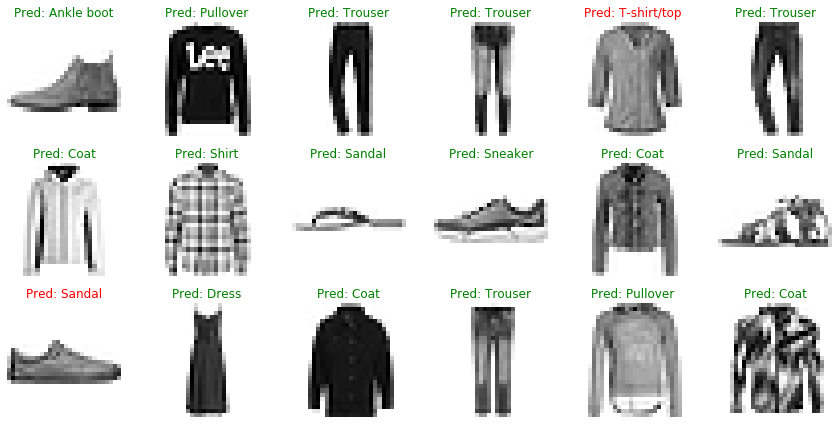

In [11]:
plot_images(test_images, test_labels, adv_model.call(test_images).numpy(), 3, 6)

Next, we check the performance on the adversarial attacks on these images. We should see that the network makes much better predictions than before, guessing correctly on roughly 3/4 of the images:

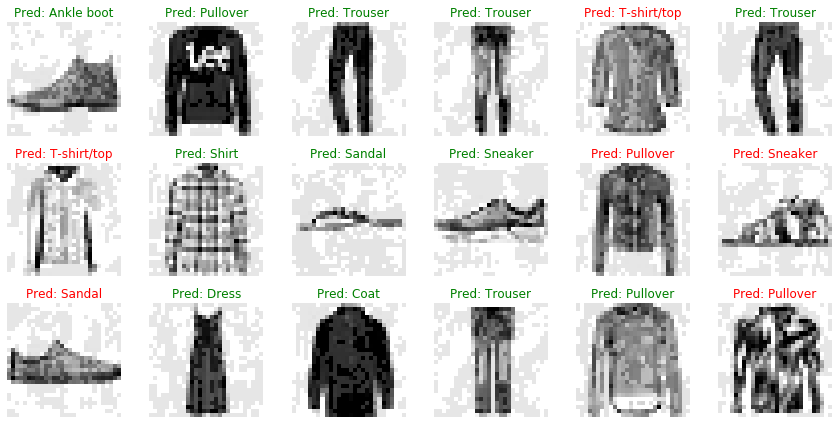

In [12]:
plot_images(perturbed_images, test_labels, adv_model.call(perturbed_images).numpy(), 3, 6)

__Extra Credit (10% of assignment)__: Modify the above training code so that it logs the _adversarial accuracy_. That is, at each epoch you adversarially attack each test image, and report the current model's accuracy on these attacked images, along with the train/test loss/accuracy.

__Extra Credit (20% of assignment)__: Implement another adversarial attack! Here's one idea: take (multiple) steps in the direction of the gradient (i.e. run gradient descent for a few iterations). For credit, the adversary should be "successful", and able to fool the ``simple_model`` on over half of the test instances.